# B/plasma figures

## Inputs

In [1]:
source('jupyterFunctions_perCellType.R')

In [2]:
CT <- 'Bplasma'
CT_label <- 'B/plasma'
data_prefix <- paste(sep='','../data/',CT,'/',CT)
ATAC_meta <- readRDS(paste(sep='',data_prefix,'_ATAC_meta.rds'))
chosenPeaks <- readRDS(paste(sep='',data_prefix,'_chosenPeaks.rds'))
diffPeaks <- readRDS(paste(sep='',data_prefix,'_diffPeaks.rds'))
diffGenes <- readRDS(paste(sep='',data_prefix,'_diffGenes.rds'))
snATAC_pxc_norm <- readRDS(paste(sep='',data_prefix,'_snATAC_pxc_norm.rds'))
snRNA_gxc_norm <- readRDS(paste(sep='',data_prefix,'_snRNA_gxc_norm.rds'))
snATAC_pxCT_norm <- readRDS(paste(sep='',data_prefix,'_snATAC_pxCT_norm.rds'))
snRNA_gxCT_norm <- readRDS(paste(sep='',data_prefix,'_snRNA_gxCT_norm.rds'))
chromVARz_mat <- readRDS(paste(sep='',data_prefix,'_ArchR_chromVARz_JASPAR2020.rds'))
ArchR_padj <- readRDS(paste(sep='',data_prefix,'_ArchR_padj_JASPAR2020.rds'))
CITE_meta <- readRDS(paste(sep='',data_prefix,'_CITE_meta.rds'))
class_state_df <- readRDS(paste(sep='',data_prefix,'_class_state_df.rds'))
LDA_res <- readRDS(paste(sep='',data_prefix,'_LDA_stats.rds'))

In [3]:
ATAC_colors <- readRDS('../data/misc/ATAC_class_colors.rds')
CITE_colors <- readRDS('../data/misc/CITE_state_colors.rds')
ATAC_CITE_conv_df <- readRDS('../data/misc/ATAC_CITE_sample_conversion.rds')

In [26]:
save_dir <- NA #'../output_v14/' #or NA if don't want to save
file_extension <- '.pdf'
data_extension <- '_sourceData.txt'

## ATAC classes

In [5]:
#setting class order
class_order <- c('BA-3','BA-4','BA-2','BA-5','BA-0','BA-1')
all(class_order %in% ATAC_meta$cluster_abbr)

class_conv_df <- unique(ATAC_meta[,c('cluster_name','cluster_abbr')])
rownames(class_conv_df) <- class_conv_df$cluster_abbr
full_class_order <- class_conv_df[class_order,'cluster_name']

[1] TRUE

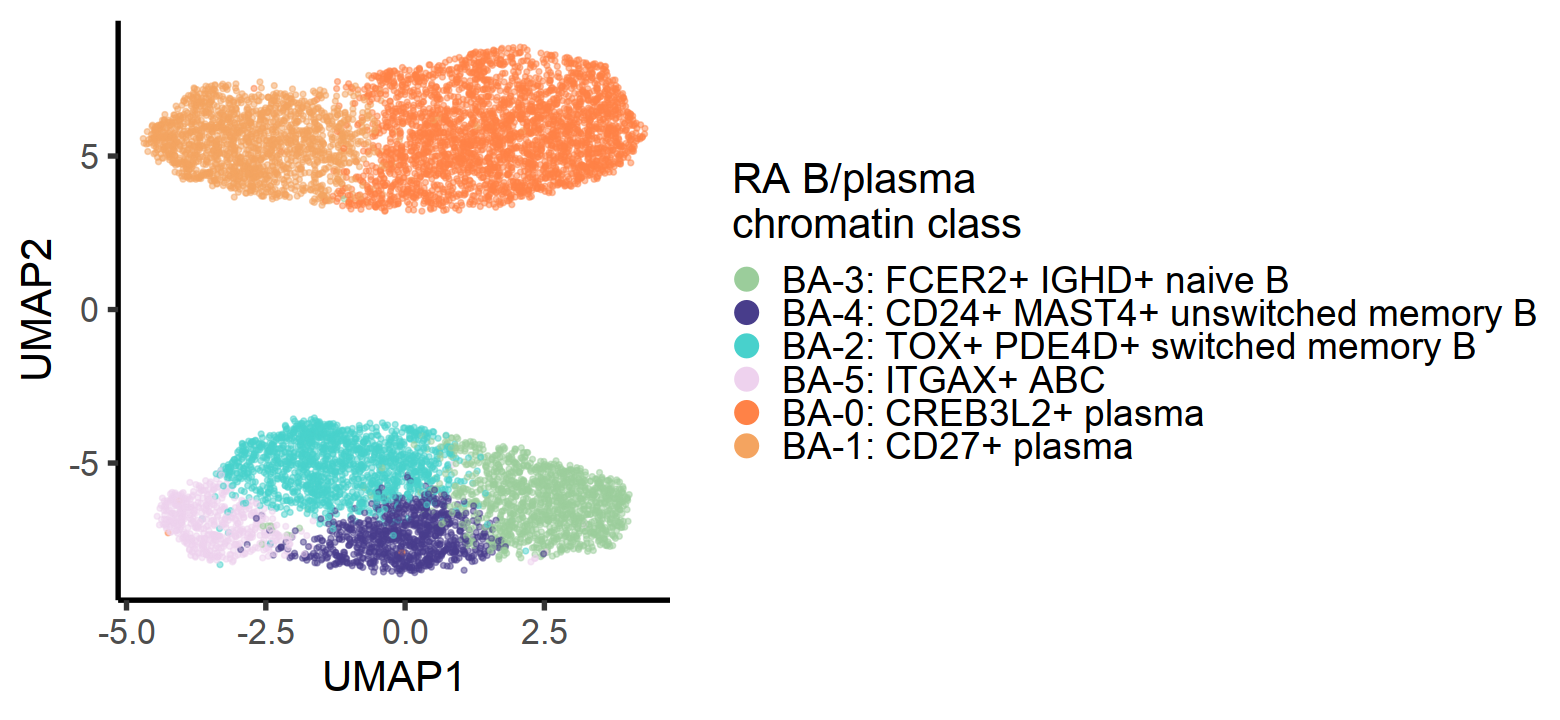

In [6]:
#Fig 5a

options(repr.plot.height=6,repr.plot.width=13)
toPlot <- ATAC_meta[,c('UMAP1','UMAP2','cluster_name')]
toPlot$cluster_name <- factor(toPlot$cluster_name,levels=full_class_order)
g <- ggplot(toPlot,aes_string(x='UMAP1',y='UMAP2',color='cluster_name')) + geom_point(size=1,alpha=0.5) + 
        theme_classic(base_size=25) + scale_color_manual(values=ATAC_colors) + 
        labs(color=paste(sep='','RA ',CT_label,'\nchromatin class')) + 
        theme(legend.text=element_text(size=22)) + 
        guides(colour = guide_legend(override.aes = list(size=6,alpha=1)))
print(g)

colnames(toPlot) <- c('UMAP1','UMAP2',paste('RA',CT_label,'chromatin class'))

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_ATAC_class_UMAP',file_extension),
           plot=g,units='in',height=6,width=13,dpi=600)
    write.table(toPlot,paste(sep='',save_dir,CT,'_ATAC_class_UMAP',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

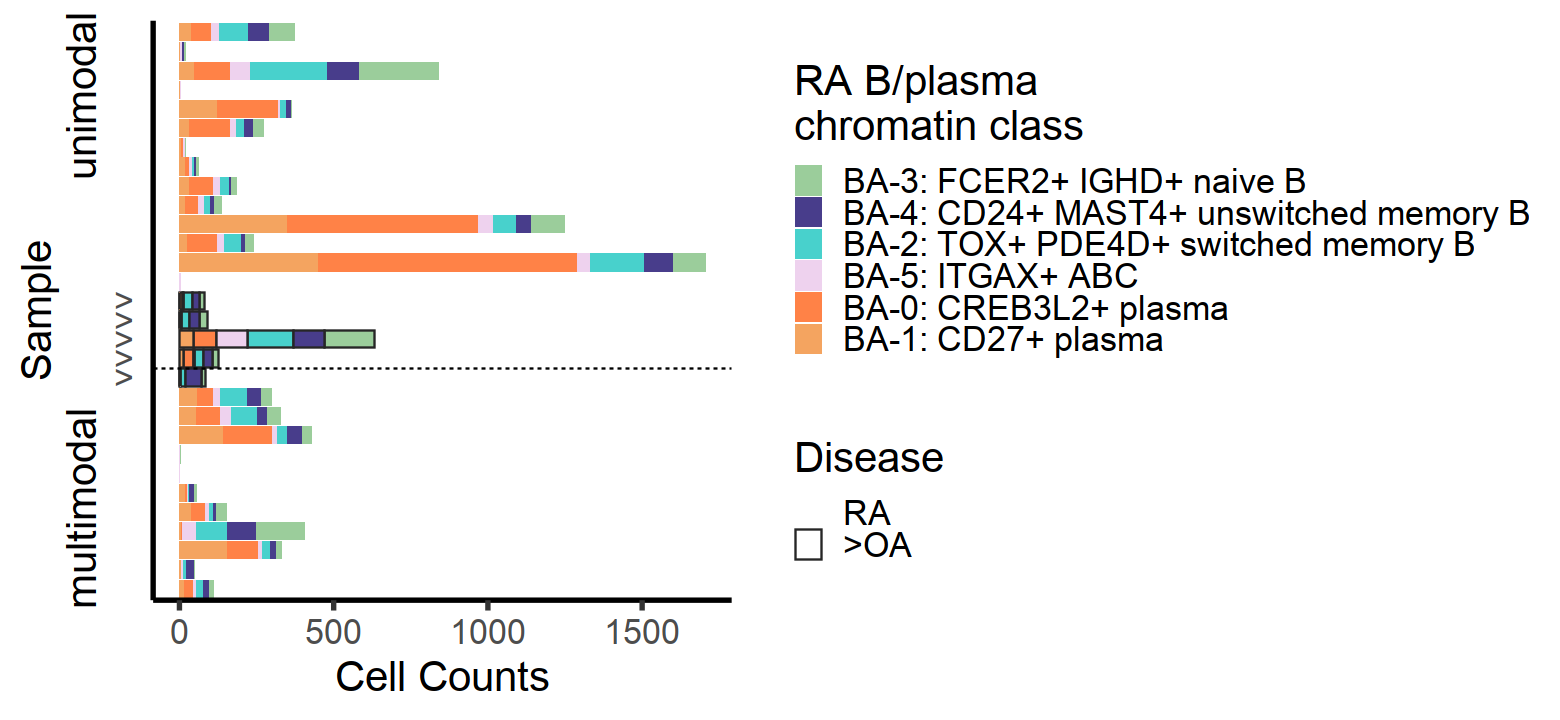

In [7]:
#Fig S6a

options(repr.plot.height=6,repr.plot.width=13)
r <- cellCount_bySample_barPlot(ATAC_meta,'sample','cluster_name',paste(sep='','RA ',CT_label,'\nchromatin class'),
                                ATAC_colors,res_order=full_class_order)
g <- r$plot
df <- r$data
print(g)

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_ATAC_class_cellCount',file_extension),
           plot=g,units='in',height=6,width=13,dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_ATAC_class_cellCount',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

In [8]:
#Table S6

toSave <- table(ATAC_meta[,c('cluster_name','disease')])
toSave

if(!is.na(save_dir)) write.table(toSave,sep='\t',col.names=T,row.names=T,quote=F,
                                 file=paste(sep='',save_dir,CT,'_ATAC_class_disease_cellCount.txt'))

                                        disease
cluster_name                               OA   RA
  BA-0: CREB3L2+ plasma                   118 2752
  BA-1: CD27+ plasma                       61 1590
  BA-2: TOX+ PDE4D+ switched memory B     246 1201
  BA-3: FCER2+ IGHD+ naive B              237 1053
  BA-4: CD24+ MAST4+ unswitched memory B  236  636
  BA-5: ITGAX+ ABC                        116  395

## ATAC cluster markers

In [9]:
chosenGenes <- names(chosenPeaks)
chosenPeaks <- chosenPeaks[!is.na(chosenPeaks)] #NA means no peak in gene's promoter

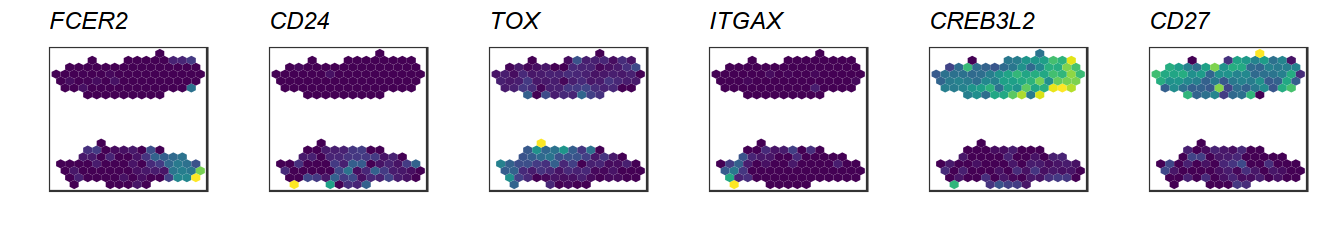

In [10]:
#Fig 5b bottom

genes_forUMAPs <- c('FCER2','CD24','TOX','ITGAX','CREB3L2','CD27')
if(!all(genes_forUMAPs %in% names(chosenPeaks))) stop('Genes for UMAP not in chosen genes')

multiome_cells <- rownames(ATAC_meta[which(ATAC_meta$assay=='snATAC'),])

options(repr.plot.height=2,repr.plot.width=11)
g <- plot_markerPeaks_norm_hex_v2(ATAC_meta[multiome_cells,],snRNA_gxc_norm[genes_forUMAPs,multiome_cells],'UMAP1','UMAP2',
                                  plot_genes=genes_forUMAPs,plotCol=length(genes_forUMAPs),
                                  titleSize=14,hex_bins=16,cutCap=0)
grid.draw(g)
if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_markerGene_UMAP',file_extension),
                            plot=g,units='in',height=2,width=11,dpi=600)

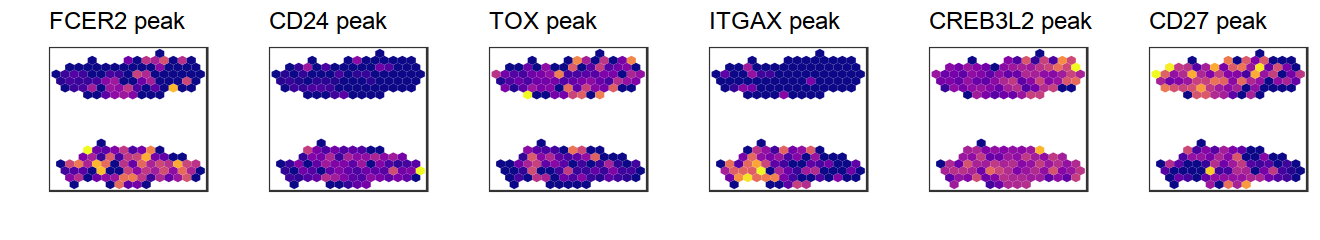

In [11]:
#Fig 5b top

toPlot <- snATAC_pxc_norm[unname(chosenPeaks[genes_forUMAPs]),multiome_cells] 
rownames(toPlot) <- paste(sep='',names(chosenPeaks[genes_forUMAPs]),' peak')

options(repr.plot.height=2,repr.plot.width=11)
g <- plot_markerPeaks_norm_hex_v2(ATAC_meta[multiome_cells,],toPlot,'UMAP1','UMAP2',
                                  plot_genes=rownames(toPlot),plotCol=nrow(toPlot),titleSize=14,hex_bins=16,cutCap=0,
                                  titleFace='plain',colorOpt='plasma')
grid.draw(g)
if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_markerPeak_UMAP',file_extension),
                            plot=g,units='in',height=2,width=11,dpi=600)

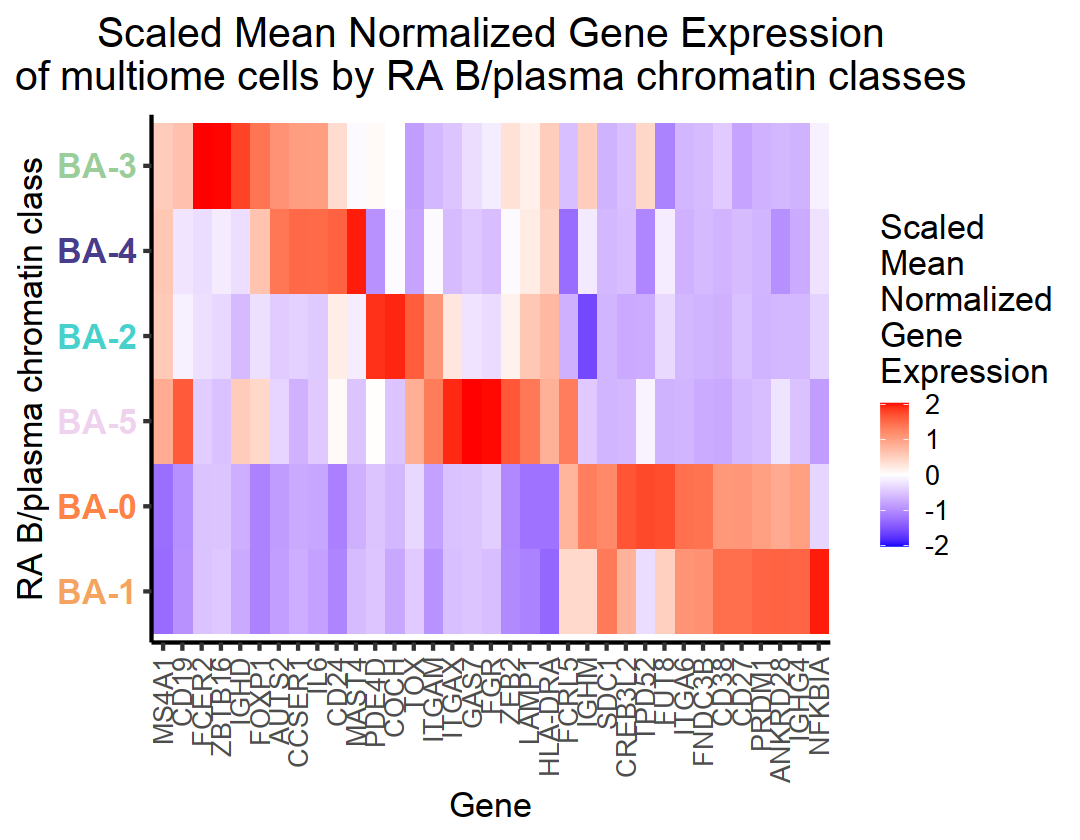

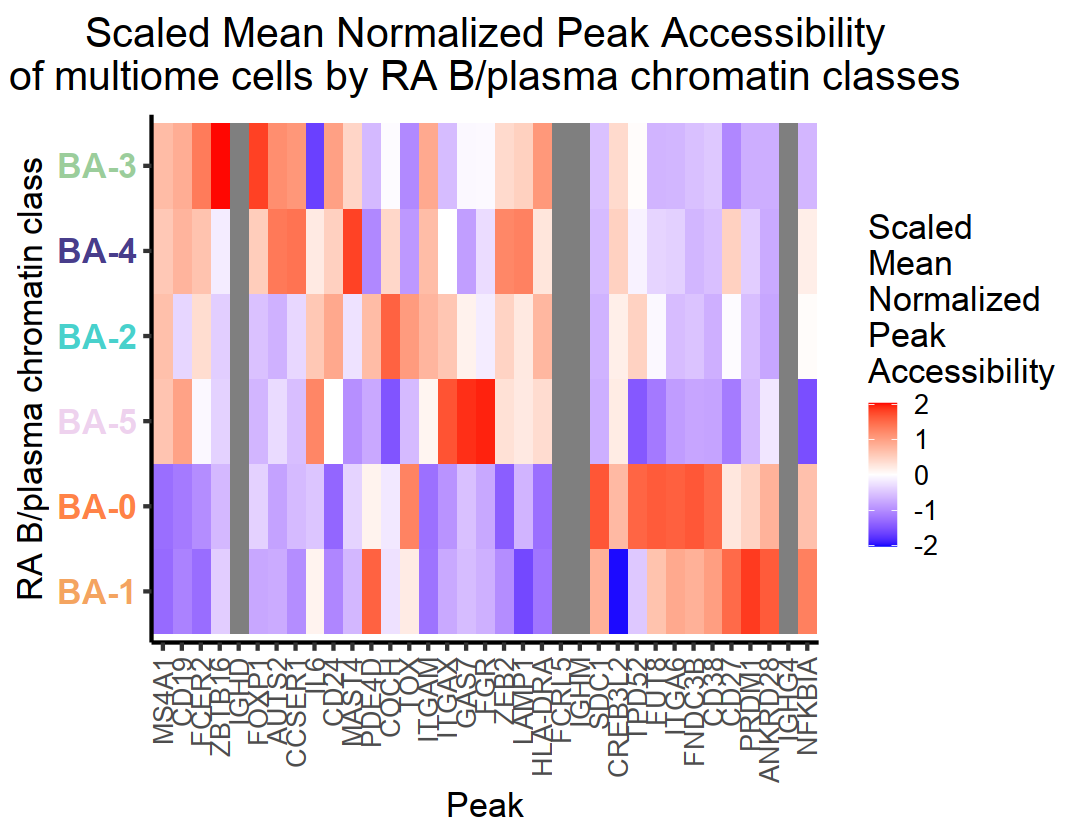

Comparing 186 gene/class combinations


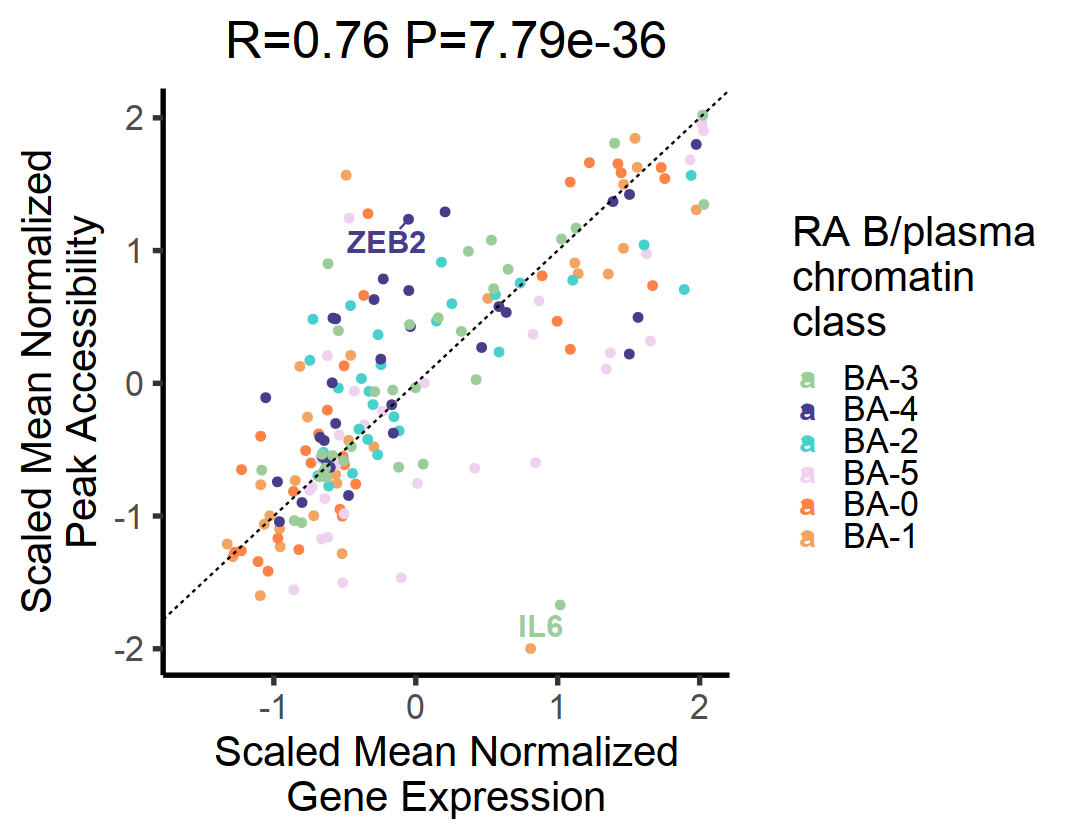

In [12]:
#Fig S6b

res <- scaleFeat_forHeatmap(chosenGenes,class_order,chosenPeaks,snRNA_gxCT_norm,snATAC_pxCT_norm)
snRNA_gxCT_norm_subset_scaled <- res$gxCT_norm_subset_scaled
snATAC_pxCT_norm_subset_scaled <- res$pxCT_norm_subset_scaled
fxCT_norm_subset_scaled <- res$fxCT_norm_subset_scaled

scale_lim <- max(abs(snRNA_gxCT_norm_subset_scaled),abs(snATAC_pxCT_norm_subset_scaled),na.rm=TRUE)

options(repr.plot.height=7,repr.plot.width=9)
g <- pseudobulk_scaled_heatmap(snRNA_gxCT_norm_subset_scaled,'Gene',paste('RA',CT_label,'chromatin class'),
                               'Scaled\nMean\nNormalized\nGene\nExpression',
                               plotTit=paste('Scaled Mean Normalized Gene Expression\nof multiome cells by RA',
                                             CT_label,'chromatin classes'),
                               scale_lim=scale_lim,clustColors=ATAC_colors)
print(g)
if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_markerGene_heatmap',file_extension),
                            plot=g,units='in',height=7,width=9,dpi=600)

g <- pseudobulk_scaled_heatmap(snATAC_pxCT_norm_subset_scaled,'Peak',paste('RA',CT_label,'chromatin class'),
                               'Scaled\nMean\nNormalized\nPeak\nAccessibility',
                               plotTit=paste('Scaled Mean Normalized Peak Accessibility\nof multiome cells by RA',
                                             CT_label,'chromatin classes'),
                               scale_lim=scale_lim,clustColors=ATAC_colors)
print(g)
if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_markerPeak_heatmap',file_extension),
                            plot=g,units='in',height=7,width=9,dpi=600)

pearR <- cor.test(fxCT_norm_subset_scaled$gene_norm_scale,fxCT_norm_subset_scaled$peak_norm_scale,
               method='pearson')

fxCT_norm_subset_scaled$label <- ''
fxCT_norm_subset_scaled[which(fxCT_norm_subset_scaled$gene=='ZEB2' & fxCT_norm_subset_scaled$cluster_abbr=='BA-4'),
                        'label'] <- 'ZEB2'
fxCT_norm_subset_scaled[which(fxCT_norm_subset_scaled$gene=='IL6' & fxCT_norm_subset_scaled$cluster_abbr=='BA-3'),
                        'label'] <- 'IL6'

fxCT_norm_subset_scaled$cluster_abbr <- factor(fxCT_norm_subset_scaled$cluster_abbr,levels=class_order)
g <- ggplot(fxCT_norm_subset_scaled,
            aes_string(x='gene_norm_scale',y='peak_norm_scale',color='cluster_abbr',label='label')) + 
        geom_point(size=2) + theme_classic(base_size=25) + scale_color_manual(values=ATAC_colors) + 
        labs(x='Scaled Mean Normalized\nGene Expression',
             y='Scaled Mean Normalized\nPeak Accessibility',
             color=paste(sep='','RA ',CT_label,'\nchromatin\nclass')) +
        geom_abline(slope=1,intercept=0,linetype='dashed') + 
        ggtitle(paste(sep='','R=',round(pearR$estimate,2),' P=',signif(pearR$p.value,3))) + 
        theme(plot.title=element_text(hjust = 0.5)) + geom_text_repel(box.padding = 0.5,size=6.5,fontface='bold',seed=0) 
suppressWarnings(print(g)) #points excluded if peak does not exist
cat(paste('Comparing',nrow(fxCT_norm_subset_scaled[which(!is.na(fxCT_norm_subset_scaled$peak_norm_scale)),]),
          'gene/class combinations\n'))

df <- fxCT_norm_subset_scaled[,c('gene','cluster_abbr','gene_norm_scale','peak_norm_scale')]
colnames(df) <- c('Gene',paste('RA',CT_label,'chromatin class'),
                  'Scaled Mean Normalized Gene Expression','Scaled Mean Normalized Peak Accessibility')

if(!is.na(save_dir)){
    suppressWarnings(ggsave(file=paste(sep='',save_dir,CT,'_markerGenePeak_scatterplot',file_extension),
                            plot=g,units='in',height=7,width=9,dpi=600))
    write.table(df,paste(sep='',save_dir,CT,'_markerGenePeak_scatterplot',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

## Single cell differential features

In [13]:
#Table S9

sc_diffFeat_df <- get_differential_features(diffPeaks,diffGenes,unique(ATAC_meta[,c('cluster_abbr','cluster_name')]),
                                            snRNA_gxCT_norm_subset_scaled)
sc_diffFeat_df$class <- factor(sc_diffFeat_df$class,levels=rev(class_order))
toSave <- sc_diffFeat_df[order(sc_diffFeat_df$class,sc_diffFeat_df$peakPadj,decreasing=TRUE),]

if(!is.na(save_dir)) write.table(toSave,sep='\t',col.names=T,row.names=F,quote=F,
                                 file=paste(sep='',save_dir,CT,'_diffFeat.txt'))

## TFs

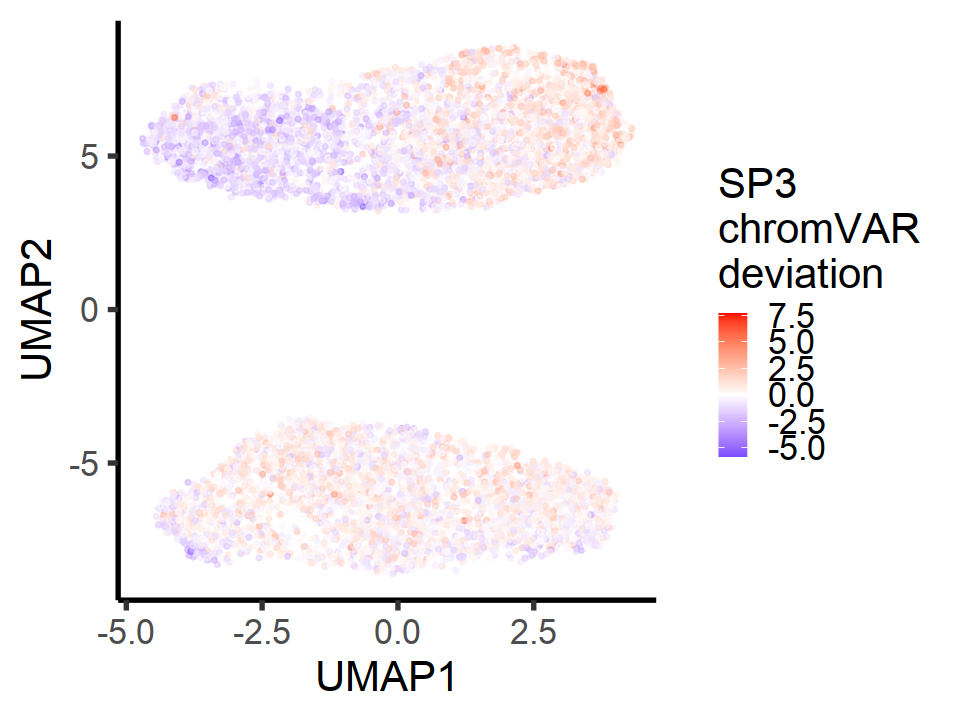

In [14]:
#Fig 5c left

#ArchR removed donors with two or fewer cells, so one sample with only two B/plasma cells was removed
cells_kept <- rownames(ATAC_meta[which(rownames(ATAC_meta) %in% colnames(chromVARz_mat)),])

motif_toPlot <- 'SP3_522'
toPlot <- cbind(ATAC_meta[cells_kept,],'motif'=chromVARz_mat[motif_toPlot,cells_kept])

options(repr.plot.height=6,repr.plot.width=8)
g <- ggplot(toPlot,aes_string(x='UMAP1',y='UMAP2',color='motif')) + geom_point(size=1,alpha=0.5) + 
        theme_classic(base_size=25) + scale_color_gradient2(low='blue',mid='white',high='red',midpoint=0) +
        labs(color=paste(sep='',str_split_fixed(motif_toPlot,'_',2)[,1],'\nchromVAR\ndeviation'))
print(g)

df <- toPlot[,c('UMAP1','UMAP2','motif')]
colnames(df) <- c('UMAP1','UMAP2',paste(str_split_fixed(motif_toPlot,'_',2)[,1],'chromVAR deviations'))

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_motif_',motif_toPlot,'_UMAP',file_extension),
           plot=g,units='in',height=6,width=8,dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_motif_',motif_toPlot,'_UMAP',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

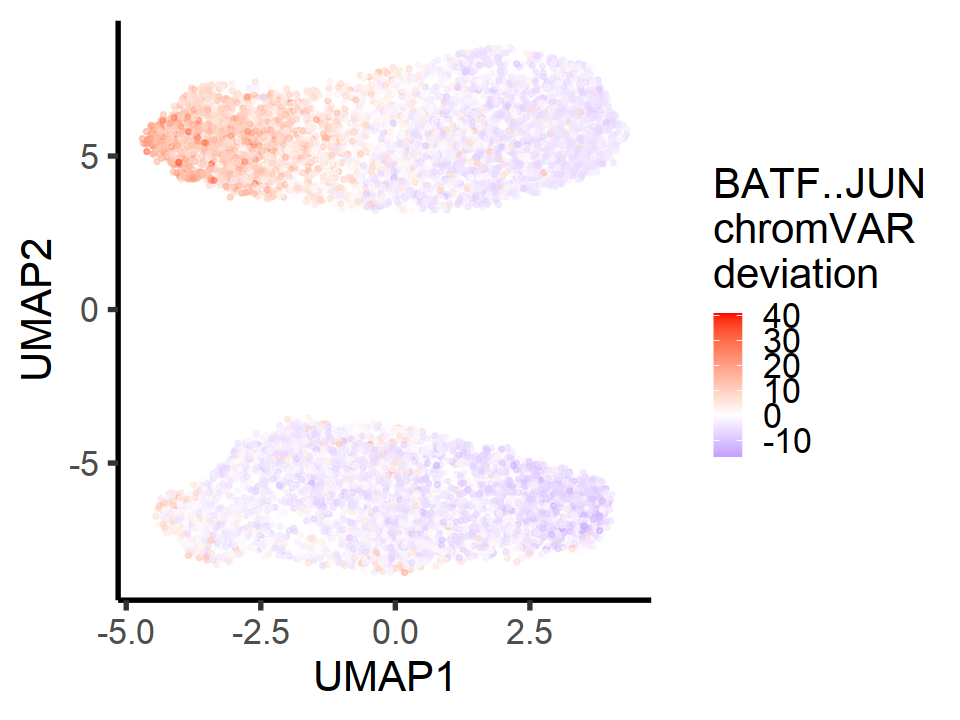

In [15]:
#Fig S6c

motif_toPlot <- 'BATF..JUN_485'
toPlot <- cbind(ATAC_meta[cells_kept,],'motif'=chromVARz_mat[motif_toPlot,cells_kept])

options(repr.plot.height=6,repr.plot.width=8)
g <- ggplot(toPlot,aes_string(x='UMAP1',y='UMAP2',color='motif')) + geom_point(size=1,alpha=0.5) + 
        theme_classic(base_size=25) + scale_color_gradient2(low='blue',mid='white',high='red',midpoint=0) +
        labs(color=paste(sep='',str_split_fixed(motif_toPlot,'_',2)[,1],'\nchromVAR\ndeviation'))
print(g)

df <- toPlot[,c('UMAP1','UMAP2','motif')]
colnames(df) <- c('UMAP1','UMAP2',paste(str_split_fixed(motif_toPlot,'_',2)[,1],'chromVAR deviations'))

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_motif_',str_replace(motif_toPlot,'\\.\\.','-'),
                      '_UMAP',file_extension),
           plot=g,units='in',height=6,width=8,dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_motif_',str_replace(motif_toPlot,'\\.\\.','-'),
                         '_UMAP',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

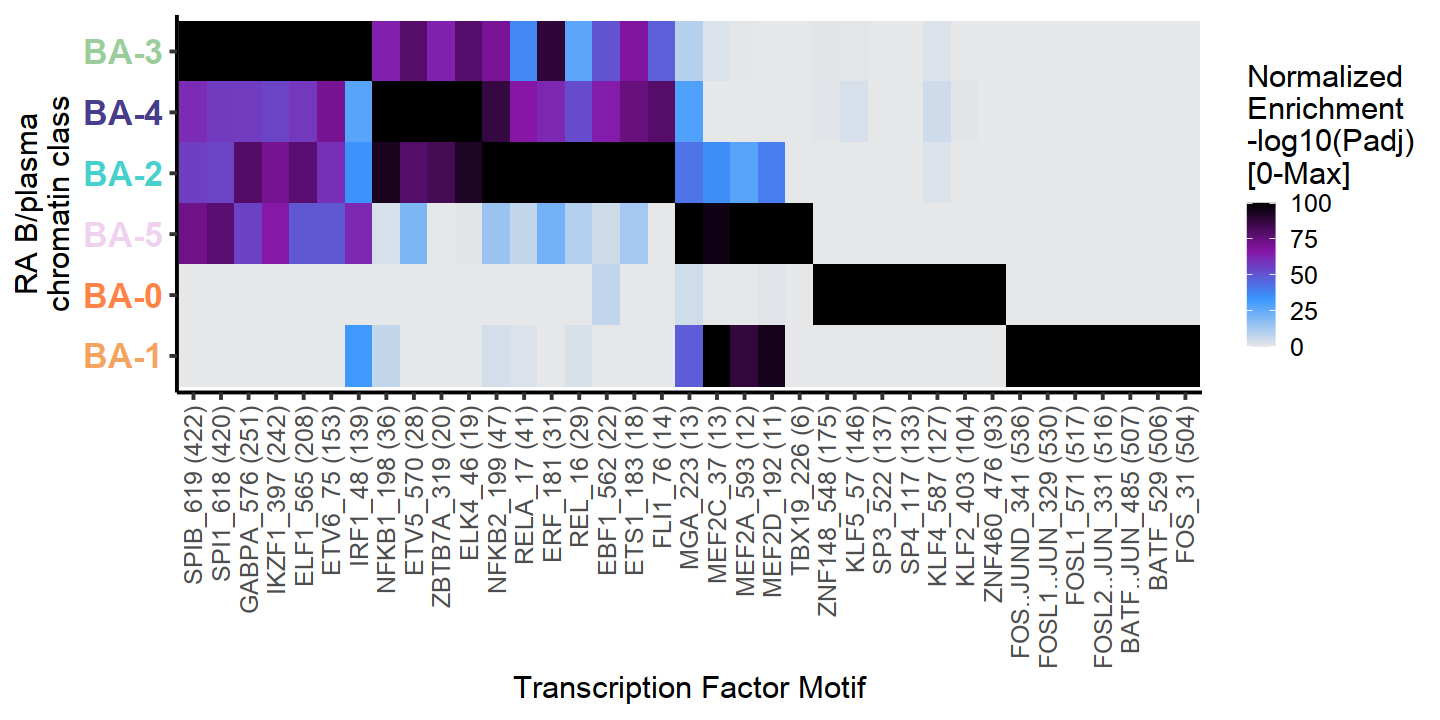

In [16]:
#Fig 5c right

if(!identical(sort(colnames(ArchR_padj)),
              sort(colnames(snRNA_gxCT_norm)))) stop('mxCT and gxCT matrices do not have same CT.')

motifs_res <- ArchR_topMotifs_KWspin(ArchR_padj,snRNA_gxCT_norm,cOrd=class_order,cColors=ATAC_colors,
                                     minE=5,num_mot=7,minGE=0.05,withinE=0.95,
                                     mLab='Transcription Factor Motif',
                                     cLab=paste(sep='','RA ',CT_label,'\nchromatin class'))
g <- motifs_res$motE
top_motifs_df <- motifs_res$df
top_TFs_df <- motifs_res$TFdf

options(repr.plot.height=6,repr.plot.width=12)
print(g)

if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_motif_heatmap',file_extension),
                            plot=g,units='in',height=6,width=12,dpi=600)

In [17]:
#Table S5

top_TFs_df <- top_TFs_df[!duplicated(top_TFs_df$class_tf),]
tf_colors <- ATAC_colors[as.character(top_TFs_df$cluster_abbr)]
names(tf_colors) <- top_TFs_df$tf

tf_wilcox_df <- TF_exp_wilcox_cells_byClass(ATAC_meta,snRNA_gxc_norm,top_TFs_df,
                                            'cluster_abbr',paste(sep='','RA ',CT_label,' chromatin class'),
                                            cOrd=class_order,clustColors=ATAC_colors,motColors=tf_colors)

if(!is.na(save_dir)) write.table(tf_wilcox_df,file=paste(sep='',save_dir,CT,'_TFexp_byClass_WilcoxonFDR.txt'),
                                 quote=FALSE,sep='\t',row.names=FALSE)

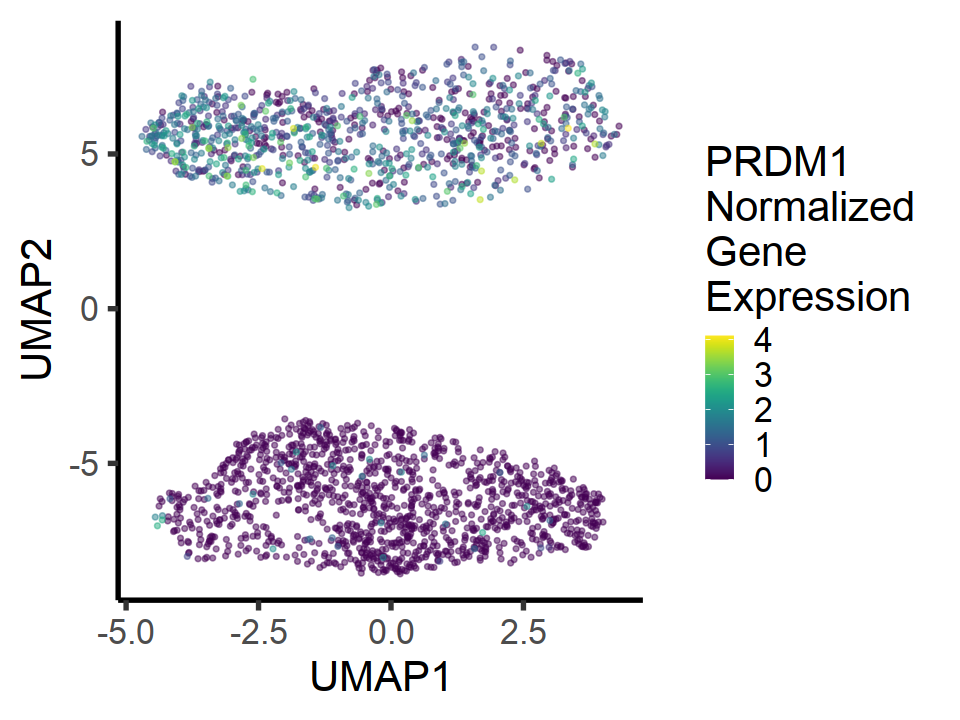

In [18]:
#Fig 5d left

gene_toPlot <- 'PRDM1'
toPlot <- cbind(ATAC_meta[multiome_cells,],'gene'=snRNA_gxc_norm[gene_toPlot,multiome_cells])

options(repr.plot.height=6,repr.plot.width=8)
g <- ggplot(toPlot[order(toPlot$gene),],aes_string(x='UMAP1',y='UMAP2',color='gene')) + 
                geom_point(size=1,alpha=0.5) + 
                theme_classic(base_size=25) + scale_color_viridis(option = 'viridis') + 
                labs(color=paste(sep='',gene_toPlot,'\nNormalized\nGene\nExpression'))
print(g)

df <- toPlot[,c('UMAP1','UMAP2','gene')]
colnames(df) <- c('UMAP1','UMAP2',paste(gene_toPlot,'Normalized Gene Expression'))

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_gene_',gene_toPlot,'_UMAP',file_extension),
           plot=g,units='in',height=6,width=8,dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_gene_',gene_toPlot,'_UMAP',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

## Transcriptional Cell States

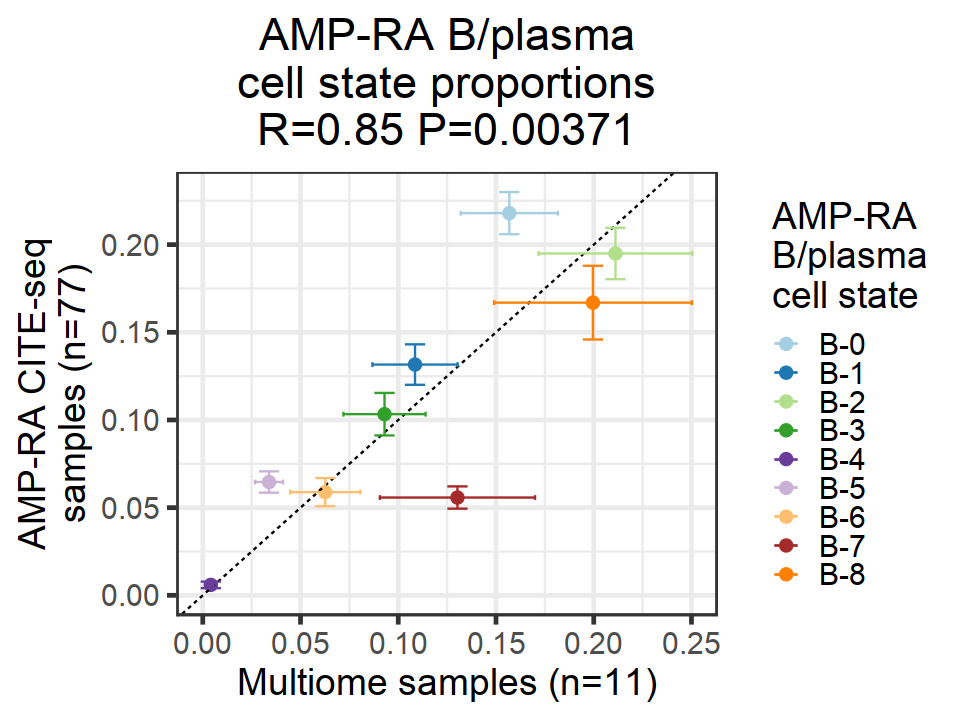

In [19]:
#Fig S10d

options(repr.plot.height=6,repr.plot.width=8)
r <- symp_prop_df(ATAC_meta[multiome_cells,],CITE_meta,
                  paste(sep='','Multiome samples (n=',
                        length(unique(ATAC_meta[multiome_cells,'sample'])),')'),
                  paste(sep='','AMP-RA CITE-seq\nsamples (n=',
                        length(unique(CITE_meta$sample)),')'),
                  paste(sep='','AMP-RA\n',CT_label,'\ncell state'),
                  tLab=paste(sep='','AMP-RA ',CT_label,'\ncell state proportions\n'),
                  clustColors=CITE_colors)
g <- r$plot
df <- r$data
print(g)

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_ATAC_CITE_state_prop',file_extension),
           plot=g,units='in',height=6,width=8,dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_ATAC_CITE_state_prop',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

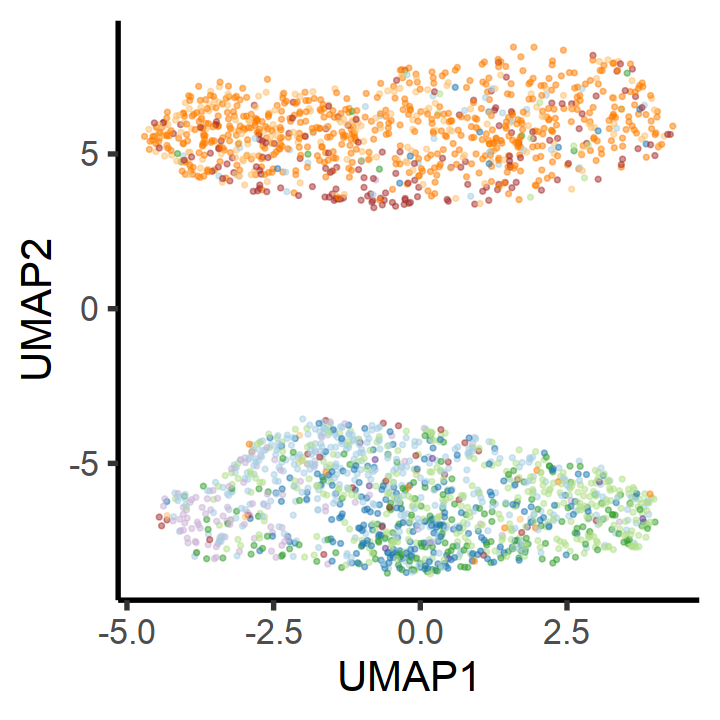

In [20]:
#Fig S10g left

options(repr.plot.height=6,repr.plot.width=6)
g <- ggplot(ATAC_meta[multiome_cells,],aes_string(x='UMAP1',y='UMAP2',color='CITE')) + 
        geom_point(size=1,alpha=0.5) + 
        theme_classic(base_size=25) + scale_color_manual(values=CITE_colors) + 
        theme(legend.position="none")
print(g)

df <- ATAC_meta[multiome_cells,c('UMAP1','UMAP2','CITE')]
colnames(df) <- c('UMAP1','UMAP2',paste('AMP-RA',CT_label,'cell state'))

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_snATAC_state_UMAP',file_extension),
           plot=g,units='in',height=6,width=6,dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_snATAC_state_UMAP',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

In [21]:
#setting state order
class_state_df$class <- factor(class_state_df$class,levels=class_order)
state_order <- class_state_df[order(class_state_df$class,class_state_df$intOrd),'state']

state_conv_df <- unique(ATAC_meta[,c('CITE','CITE_abbr')])
rownames(state_conv_df) <- state_conv_df$CITE_abbr
full_state_order <- state_conv_df[state_order,'CITE']

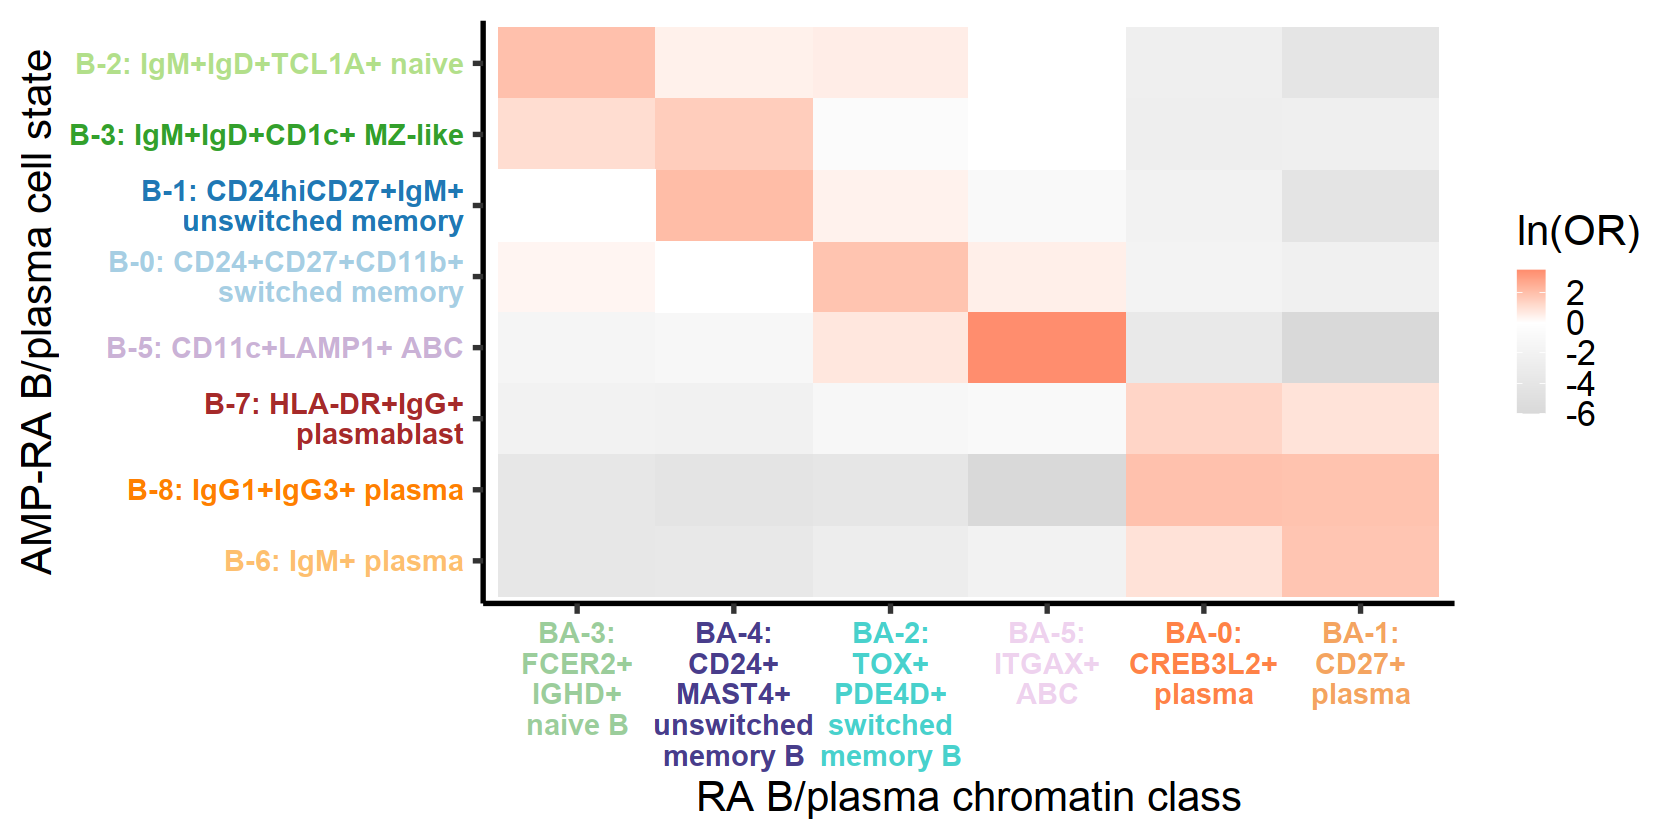

In [22]:
#Fig S10g right & Table S7

#only 9 B-4 cells, so excluding here
fisher_df <- calc_OR(ATAC_meta[which(ATAC_meta$assay=='snATAC' & ATAC_meta$CITE_abbr!='B-4'),], 'cluster_name', 'CITE')
if(!is.na(save_dir)) write.table(fisher_df[,c('cluster_name','CITE','OR','pval','padj','CI_low','CI_high')],
                                 file=paste(sep='',save_dir,CT,'_class_state_OR_table.txt'),
                                 quote=FALSE,sep='\t',row.names=FALSE)


g <- plot_OR(fisher_df, 'cluster_name', 'CITE',
             paste('RA',CT_label,'chromatin class'), paste('AMP-RA',CT_label,'cell state'),
             full_class_order, full_state_order,
             clustColors=c(ATAC_colors,CITE_colors),yLab_charLim=27)

options(repr.plot.height=7,repr.plot.width=14)
print(g)

if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_class_state_OR_heatmap',file_extension),
                            plot=g,units='in',height=7,width=14,dpi=600)

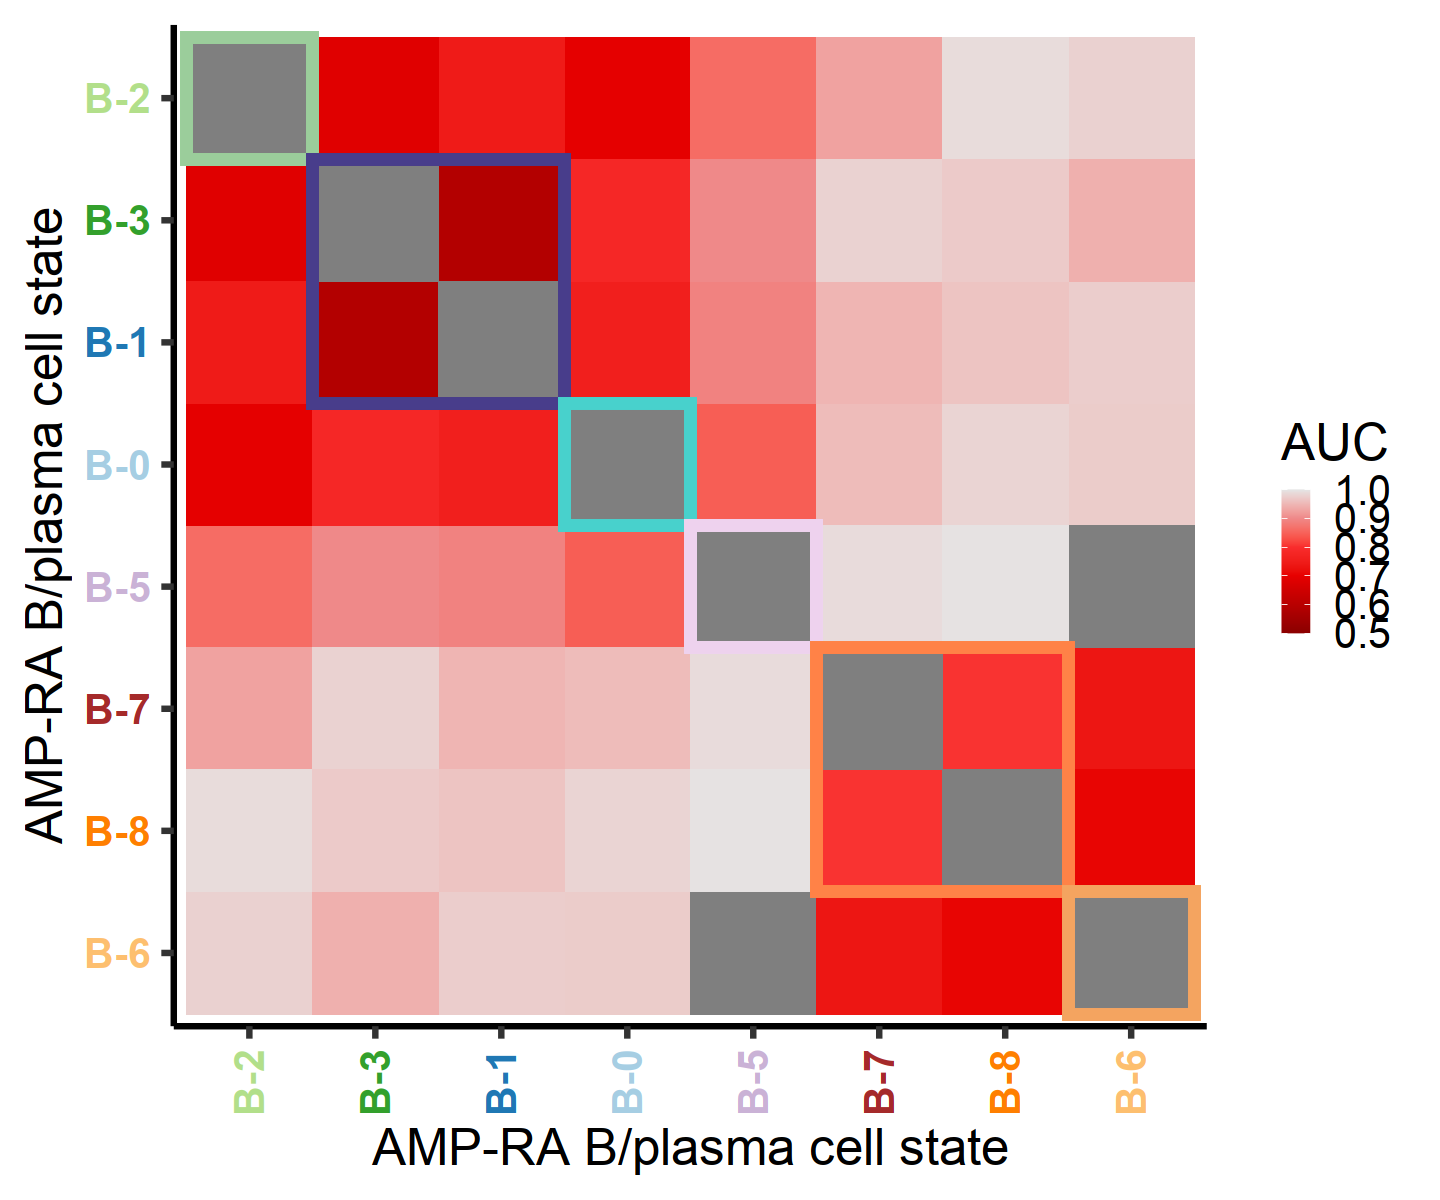

In [23]:
#Fig S14d

options(repr.plot.height=10,repr.plot.width=12)
g <- LDA_plots(LDA_res,CT,paste('AMP-RA',CT_label,'cell state'),
               class_state_df=class_state_df,ctOrd_col='intOrd',ctOrd=class_order,
               clustColors=c(CITE_colors,ATAC_colors))
print(g)

if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,CT,'_LDA_heatmap',file_extension),
                            plot=g,units='in',height=10,width=12,dpi=600)

## CITE donor proportions

Using 8 donors.


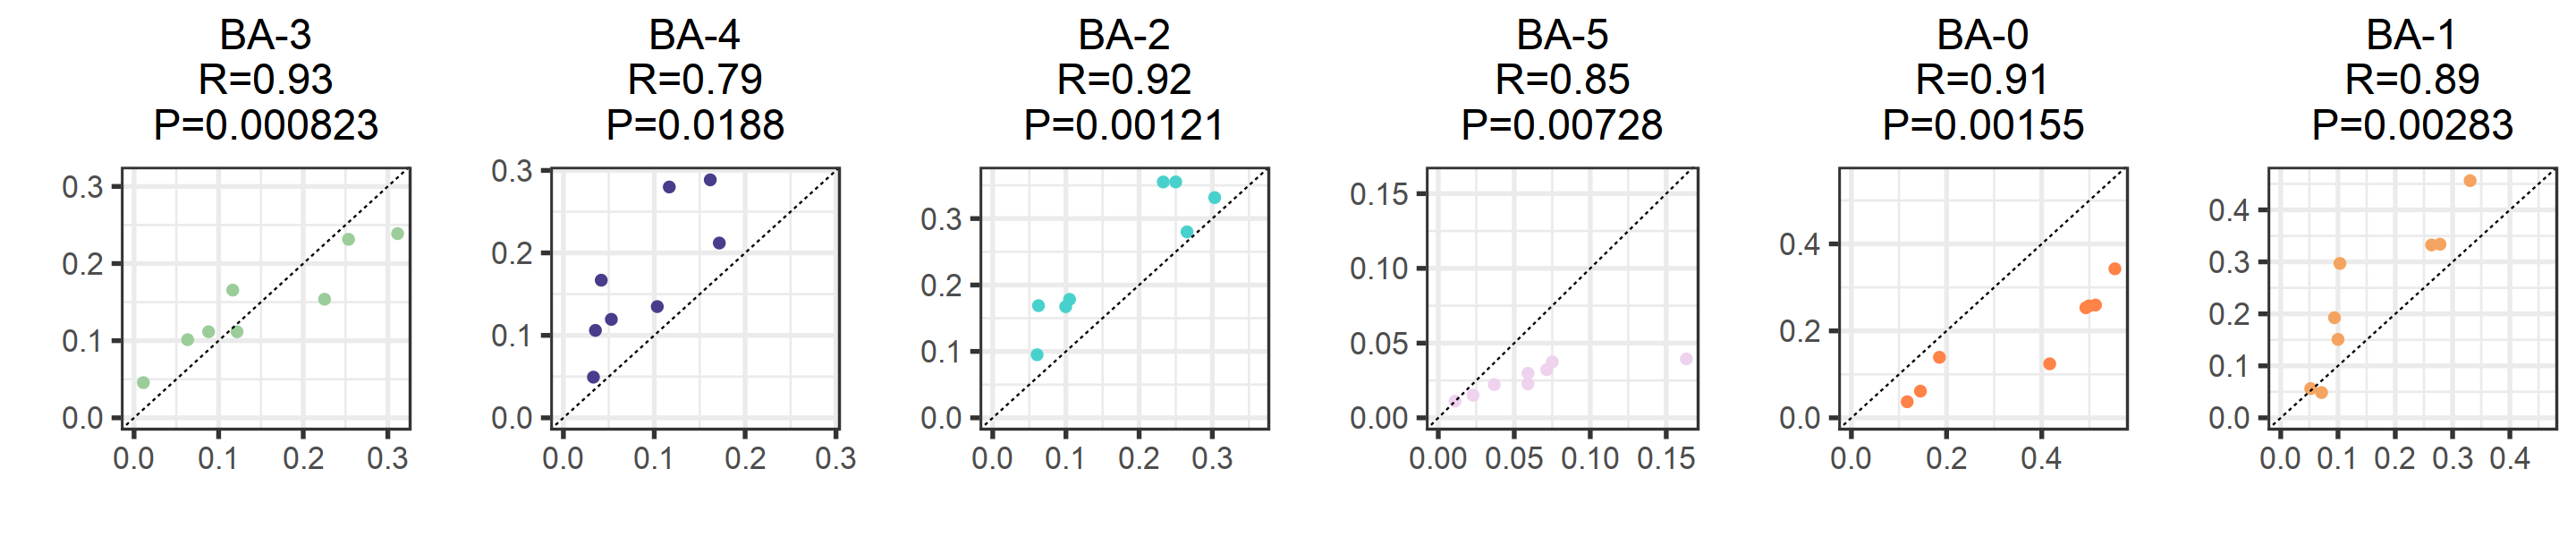

In [24]:
#Fig S16a

tVec <- sort(unique(ATAC_meta$cluster_abbr))
names(tVec) <- sort(unique(ATAC_meta$cluster_name))

options(repr.plot.height=5,repr.plot.width=4*length(unique(ATAC_meta$cluster_abbr)))
r <- donor_prop_comp_plot(ATAC_CITE_conv_df,ATAC_meta[which(ATAC_meta$assay=='scATAC'),],CITE_meta,
                          clustColors=ATAC_colors,tSize=28,tVec=tVec,aLab='',mLab='',
                          cs_order=full_class_order)
g <- r$plot
df <- r$data
grid.draw(g)

if(!is.na(save_dir)){
    ggsave(file=paste(sep='',save_dir,CT,'_ATAC_CITE_donor_prop',file_extension),
           plot=g,units='in',height=5,width=4*length(unique(ATAC_meta$cluster_abbr)),dpi=600)
    write.table(df,paste(sep='',save_dir,CT,'_ATAC_CITE_donor_prop',data_extension),
                sep='\t',col.name=TRUE,row.name=FALSE,quote=FALSE)
}

## Session Info

In [25]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/kew47/miniconda3/lib/R/lib/libRblas.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] repr_1.0.1         gridExtra_2.3      RColorBrewer_1.1-2 scales_1.1.1      
 [5] viridis_0.5.1      viridisLite_0.3.0  ggrepel_0.8.2      ggrastr_0.2.3     
 [9] tidyr_1.0.3        stringr_1.4.0      ggpubr_0.4.0       ggplot2_3.3.0     
[13] presto_1.0.0       Rcpp_1.0.4.6       ROCR_1.0-7         gplots_3.0.1.1    
[17] Rmisc_1.5.1        plyr_1.8.6         lattice_0.20-41    gtools_3.8.2      
[21] Matrix_1.2-18     

loaded via a namespace (and not attached):
 [1] jsonlite_1.7.1      carData_3.0-4       vipor_0.4.5        
 [4] cellranger_1.1.0    pillar_1.4.4        backports_1.1.6    
